# 图像增广

In [2]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

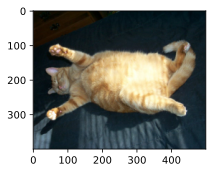

In [4]:
d2l.set_figsize()
img=d2l.Image.open('../img/cat1.jpg')
d2l.plt.imshow(img);

In [5]:
def apply(img,aug,num_rows=2,num_cols=4,scale=1.5):
    '''
    使用图像增广
    :param img:需要增广的图片
    :param aug: 使用的增广方法
    :param num_rows: 结果的行数
    :param num_cols: 结果的列数
    :param scale: 结果图像的大小,1.5意思是画大一点
    :return: 绘制num_rows行num_cols列的增广后的图片
    '''
    Y = [aug(img) for _ in  range(num_rows * num_cols)]
    d2l.show_images(Y,num_rows,num_cols,scale=scale)

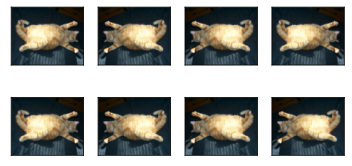

In [6]:
# 在水平位置随机旋转（50%概率翻面，50%不翻面）
apply(img,torchvision.transforms.RandomHorizontalFlip())

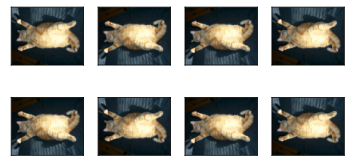

In [7]:
# 上下翻转
apply(img,torchvision.transforms.RandomVerticalFlip())

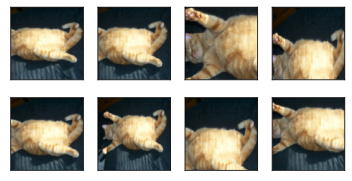

In [9]:
# 随机剪裁
#  (200,200)：不管多大区域最终resize到200x200
# scale=(0.1,1)：要在多大的区域进行裁剪，从10%到100%随机选择一个区域裁剪
# ratio=(0.5,2)：高宽比，在1；2到2:1范围内
# 先进行随机大小和随机宽高比的Crop操作，再对Crop出来的区域进行Resize操作
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200,200),scale=(0.1,1),ratio=(0.5,2))
apply(img,shape_aug)

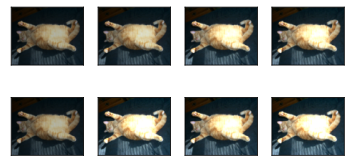

In [11]:
# 随机改变亮度
# 亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue)
# 亮度在正负0.5之间浮动
apply(img,torchvision.transforms.ColorJitter(brightness=0.5,contrast=0,saturation=0,hue=0))

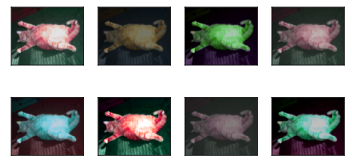

In [14]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.5)
apply(img,color_aug)

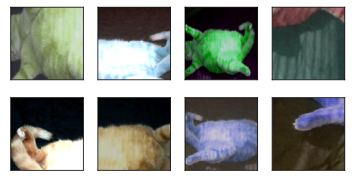

In [15]:
# 叠加多种增广方法
# 先随机水平翻转，再做颜色增广，再做形状增广
augs = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(),color_aug,shape_aug])
apply(img,augs)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data\cifar-10-python.tar.gz to ../data


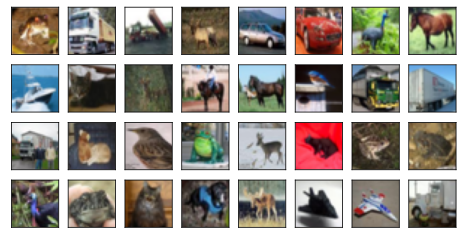

In [17]:
all_images = torchvision.datasets.CIFAR10(train=True,root="../data",download=True)
d2l.show_images([all_images[i][0] for i in range(32)],4,8,scale=1);

In [18]:
# 只用随机的左右翻转
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    # 变成4D的tensor
    torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

In [19]:
def load_cifar10(is_train,augs,batch_size):
    # 每次读取数据的时候都会apply一下augs
    dataset = torchvision.datasets.CIFAR10(
        root="../data",train=is_train,
        transform=augs,download=False)
    dataloader = torch.utils.data.DataLoader(
        dataset,batch_size=batch_size,shuffle = is_train,
        num_workers = d2l.get_dataloader_workers())
    return dataloader

In [20]:
def train_batch_ch13(net,X,y,loss,trainer,devices):
    if isinstance(X,list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    # 说明是一个训练模型
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred,y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred,y)
    return train_loss_sum,train_acc_sum

In [21]:
def train_ch13(net,train_iter,test_iter,loss,trainer,num_epochs,devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [25]:
batch_size,devices,net = 256,d2l.try_all_gpus(),d2l.resnet18(10,3) # 10个类别，3个通道（RGB）

def init_weights(m):
    if type(m) in [nn.Linear,nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs,test_augs,net,lr=0.001):
    train_iter = load_cifar10(True,train_augs,batch_size)
    test_iter = load_cifar10(True,test_augs,batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(),lr=lr)
    train_batch_ch13(net,train_iter,test_iter,loss,trainer,10,devices)

In [ ]:
%%time
train_with_data_aug(train_augs,test_augs,net)